In [ ]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals/download?datasetVersionNumber=1")




Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: danieldarbekov
Your Kaggle Key: ··········


100%|██████████| 185M/185M [00:02<00:00, 89.1MB/s]


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
import torch

dataset = ImageFolder('/content/mammals-image-classification-dataset-45-animals/mammals', transform=ToTensor())


In [ ]:
import matplotlib.pyplot as plt

def show_image(num):
  img, label  = dataset[num]

  plt.title(f'Label {dataset.classes[label]} ({label})' )
  plt.imshow(img.numpy().transpose(1, 2, 0))

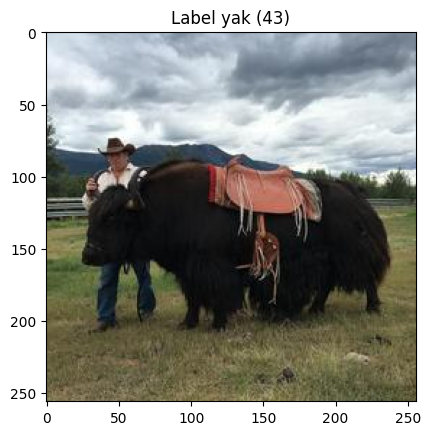

In [ ]:
show_image(13320)

In [ ]:
len(dataset.classes)

45

In [ ]:
from torch.utils.data import random_split

train_length = int(0.8 * len(dataset))
test_length = len(dataset) - train_length

train_set, test_set = random_split(dataset, [train_length , test_length])

print(train_length, "\n", test_length)

11000 
 2751


In [ ]:
train_data = DataLoader(train_set, batch_size=32, shuffle=True)

test_data = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
import torch.nn as nn

class MammalsCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.act = nn.LeakyReLU(0.1)
    self.maxpool = nn.MaxPool2d(2,2)

    self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
    self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)

    self.adapt = nn.AdaptiveAvgPool2d((1,1))
    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(64, 45)

    self.dropout = nn.Dropout(p=0.5)


  def forward(self,x):
    out = self.conv0(x)
    out = self.act(out)
    out = self.dropout(out)

    out = self.maxpool(out)

    out = self.conv1(out)
    out = self.act(out)
    out = self.dropout(out)

    out = self.maxpool(out)

    out = self.conv2(out)
    out = self.act(out)
    out = self.dropout(out)

    out = self.maxpool(out)

    out = self.conv3(out)
    out = self.act(out)
    out = self.dropout(out)

    out = self.adapt(out)
    out = self.flatten(out)

    out = self.linear1(out)
    out = self.act(out)
    out = self.dropout(out)



    return out

In [ ]:
model = MammalsCNN()

In [ ]:
model

MammalsCNN(
  (act): LeakyReLU(negative_slope=0.1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=45, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data, target = data.to(device), target.to(device)


for epoch in range(7):
    model.train()
    total_loss = 0.0

    with tqdm(train_data, desc=f'Epoch {epoch+1}/{7}', unit='batch') as t:
        for batch_idx, (data, target) in enumerate(t):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            t.set_postfix(loss=f'{loss.item():.7f}')

    average_loss = total_loss / len(train_data)
    print(f'Epoch [{epoch+1}/{7}], Average Loss: {average_loss:.7f}')

Epoch 1/7: 100%|██████████| 344/344 [31:26<00:00,  5.48s/batch, loss=3.7528474]


Epoch [1/7], Average Loss: 3.7569971


Epoch 2/7: 100%|██████████| 344/344 [31:35<00:00,  5.51s/batch, loss=3.7403619]


Epoch [2/7], Average Loss: 3.7102387


Epoch 3/7: 100%|██████████| 344/344 [31:08<00:00,  5.43s/batch, loss=3.7473366]


Epoch [3/7], Average Loss: 3.6821631


Epoch 4/7: 100%|██████████| 344/344 [31:03<00:00,  5.42s/batch, loss=3.5560229]


Epoch [4/7], Average Loss: 3.6534491


Epoch 5/7: 100%|██████████| 344/344 [31:26<00:00,  5.48s/batch, loss=3.7827513]


Epoch [5/7], Average Loss: 3.6223483


Epoch 6/7:  74%|███████▎  | 253/344 [23:19<10:18,  6.80s/batch, loss=3.4144464]

In [ ]:
model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad(), tqdm(total=len(test_data), desc='Testing', unit='batch') as t:
    for data, target in test_data:
        output = model(data)
        loss = criterion(output, target)

        test_loss += loss.item()


        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()

        total_samples += target.size(0)
        t.update(1)

average_test_loss = test_loss / len(test_data.dataset)
accuracy = correct_predictions / total_samples

print(f'Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

Testing: 100%|██████████| 86/86 [02:55<00:00,  2.04s/batch]

Test Loss: 0.0959, Accuracy: 19.19%
